In [1]:
import os
import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import cv2
from tqdm import tqdm
import torch
from torch import Tensor
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

try:
    from google.colab import drive
    drive.mount("/content/drive")
    colab = True
except:
    colab = False

In [2]:
if(colab):
    images_path = '/content/drive/MyDrive/MADS/images'
    masks_path = '/content/drive/MyDrive/MADS/masks'
    collages_path = '/content/drive/MyDrive/MADS/collages'
else:
    images_path = 'segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images'
    masks_path = 'segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks'
    collages_path = 'segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/collages'

In [3]:
image_names = [f for f in listdir(images_path) if isfile(join(images_path, f))]
mask_names =  [f for f in listdir(masks_path) if isfile(join(masks_path, f))]

In [4]:
mask = cv2.imread(masks_path + '/' + mask_names[1])

In [5]:
if(not image_names == mask_names):
    print("Ensure there is no curroption is the data")

In [6]:
mask = cv2.imread(masks_path + '/' + 'Taichi_S2_C1_00315.png')

In [7]:
mask.shape

(384, 512, 3)

In [8]:
max_x = 0
min_x = mask.shape[0]
max_y = 0
min_y = mask.shape[1]
for row in range(len(mask)):
        for column in range(mask.shape[1]):
                for channel in range(1):
                     if(mask[row][column][channel]) == 255:
                        if(min_y > row):
                            min_y = row
                        if(max_y < row):
                            max_y = row
                        if(min_x > column):
                            min_x = column
                        if(max_x < column):
                            max_x = column

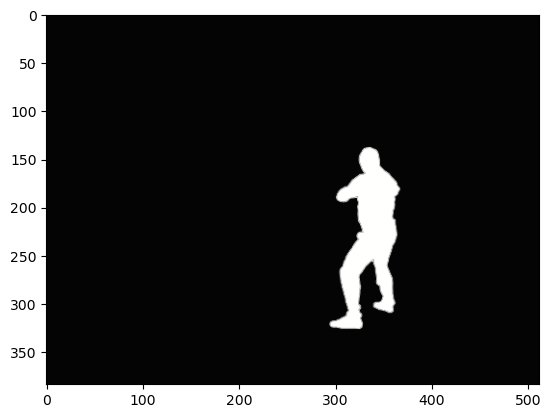

In [9]:
plt.imshow(mask)


In [10]:
color = (255, 0, 0)
thickness = 1
crop_box = cv2.rectangle(mask, (min_x, min_y), (max_x, max_y), color, thickness)

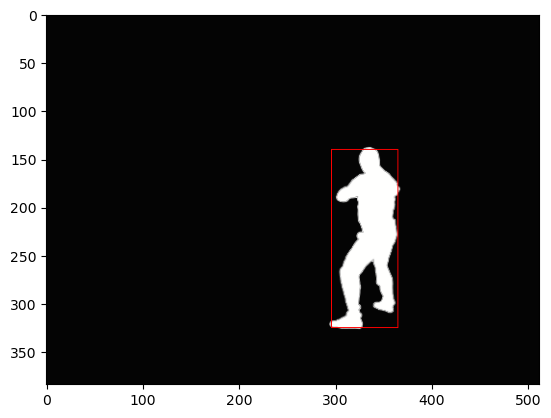

In [11]:
plt.imshow(crop_box)

In [12]:
import scipy
x_border_max = mask.shape[1]
y_border_max = mask.shape[0]

global_max_x = 0
global_min_x = x_border_max
global_max_y = 0
global_min_y = y_border_max

for mask_name in tqdm(mask_names):
    mask = cv2.imread(masks_path + '/' + mask_name)
    for row in range(len(mask)):
            for column in range(mask.shape[1]):
                    for channel in range(3):
                         if(mask[row][column][channel] == 255):
                            if(global_min_y > row):
                                global_min_y = row
                                global_min_y_image = mask_name
                            if(global_max_y < row):
                                global_max_y = row
                                global_max_y_image = mask_name
                            if(global_min_x > column):
                                global_min_x = column
                                global_min_x_image = mask_name
                            if(global_max_x < column):
                                global_max_x = column
                                global_max_x_image = mask_name

100%|██████████| 1192/1192 [23:24<00:00,  1.18s/it]


In [19]:
skip = True
if(skip):
  global_min_x = 28
  global_min_y = 52
  global_max_x = 473
  global_max_y = 383

In [20]:
print("The Crop Dimesions are ({0},{1}),({2},{3})".format(global_min_x, global_min_y, global_max_x, global_max_y))

The Crop Dimesions are (28,52),(473,383)


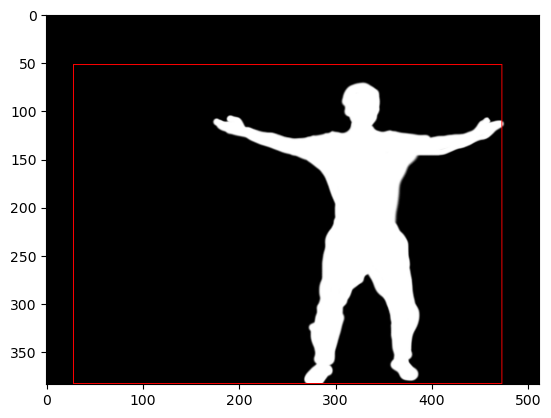

In [21]:
mask = cv2.imread(masks_path + "/" + global_max_x_image)
color = (255, 0, 0)
thickness = 1
crop_box = cv2.rectangle(mask, (global_min_x, global_min_y), (global_max_x, global_max_y), color, thickness)
plt.imshow(crop_box)

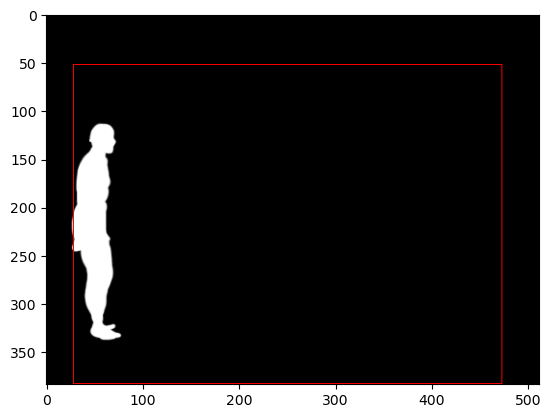

In [22]:
mask = cv2.imread(masks_path + "/" + global_min_x_image)
color = (255, 0, 0)
thickness = 1
crop_box = cv2.rectangle(mask, (global_min_x, global_min_y), (global_max_x, global_max_y), color, thickness)
plt.imshow(crop_box)

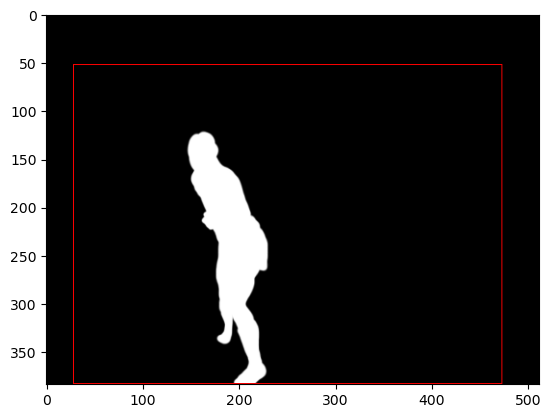

In [23]:
mask = cv2.imread(masks_path + "/" + global_max_y_image)
color = (255, 0, 0)
thickness = 1
crop_box = cv2.rectangle(mask, (global_min_x, global_min_y), (global_max_x, global_max_y), color, thickness)
plt.imshow(crop_box)

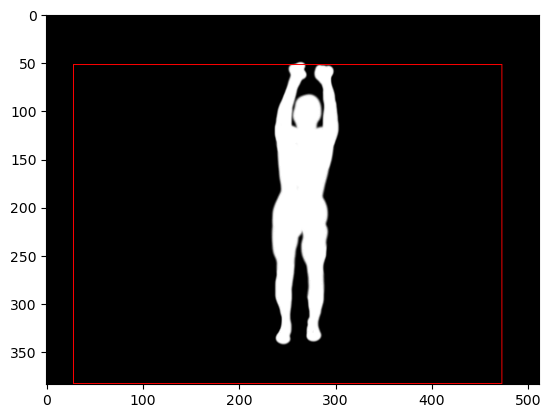

In [24]:
mask = cv2.imread(masks_path + "/" + global_min_y_image)
color = (255, 0, 0)
thickness = 1
crop_box = cv2.rectangle(mask, (global_min_x, global_min_y), (global_max_x, global_max_y), color, thickness)
plt.imshow(crop_box)

In [19]:
class Dataset(Dataset):
    def __init__(self, names):
      self.names = names
    def __len__(self):
        return len(self.names)

    def transform_image(self, image):
        image = image[global_min_x - 15:global_max_x + 15, global_min_y - 15 : global_max_y + 15, :]
        image = cv2.resize(image,(128,128))
        image /= 255.0
        image = torch.as_tensor(image, dtype=torch.float32)
        image = torch.permute(image,(2,0,1))

        return image
    def transform_mask(self, mask):

        mask = mask[global_min_x - 15:global_max_x + 15, global_min_y - 15 : global_max_y + 15]
        mask = cv2.resize(mask,(128,128))
        mask[mask>0] = 1
        return mask

    def __getitem__(self, index):
        image = self.names[index]
        image = cv2.imread(os.path.join(images_path,image), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = self.transform_image(image)

        mask = self.names[index]
        mask = cv2.imread(os.path.join(masks_path,mask),cv2.IMREAD_GRAYSCALE)
        mask = self.transform_mask(mask)
        mask = torch.as_tensor(mask, dtype=torch.long)
        return image, mask

In [20]:
X_train, X_val, _, _ = train_test_split(image_names, image_names, test_size=.2, random_state=42)

In [ ]:
len(X_val)

In [21]:
train_dataset = Dataset(X_train)
train_data_loader = DataLoader(train_dataset, batch_size= 6,  shuffle=True, num_workers=2)
val_dataset = Dataset(X_val)
val_data_loader = DataLoader(val_dataset, batch_size= 3, shuffle=True, num_workers=1)

In [22]:
train_dataset[0][0].shape

torch.Size([3, 128, 128])

In [23]:
train_dataset[0][1].shape

torch.Size([128, 128])

In [24]:
len(val_data_loader)

80

In [36]:
def train(data_loader, epoch):
    model.train()
    correct_train = 0
    log_interval = 50
    t_loss = 0

    for idx, (images, mask) in enumerate((data_loader)):
        images = images.to(device).float()
        mask = mask.to(device).long()

        outputs = model(images)

        loss = criterion(outputs, mask)
        optimizer.zero_grad()
        loss.backward()
        t_loss += loss
        optimizer.step()

        if idx % log_interval == 0 and idx > 0:
            print('Training | epoch {0} | {1}/{2} batches | loss {3}'.format(epoch, idx, len(data_loader),
            t_loss/log_interval))
            t_loss = 0
            correct_train = 0

def eval(data_loader, epoch):

    correct_train = 0
    log_interval = 40
    t_loss = 0

    for idx, (images, mask) in enumerate((data_loader)):
        optimizer.zero_grad()
        images = images.to(device).float()
        mask = mask.to(device).long()

        outputs = model(images)
        del images
        loss = criterion(outputs, mask)
        del mask
        t_loss += loss

        if (idx + 1) % log_interval == 0 and idx > 0:
            print('Validation | epoch {0} | {1}/{2} batches |  loss {3}'.format(epoch, idx, len(data_loader),
            t_loss/log_interval))
            t_loss = 0
            correct_train = 0


In [37]:
device = torch.device('cuda')
lr_rate = 2e-5

model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=.0005)
criterion = nn.CrossEntropyLoss()


for epoch in range(0,10):
  train(train_data_loader, epoch)
  eval(val_data_loader, epoch)

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


Training | epoch 0 | 50/159 batches | loss 0.17392589151859283
Training | epoch 0 | 100/159 batches | loss 0.05322422459721565
Training | epoch 0 | 150/159 batches | loss 0.056185558438301086
Validation | epoch 0 | 39/80 batches |  loss 0.07139723747968674
Validation | epoch 0 | 79/80 batches |  loss 0.03728504106402397
Training | epoch 1 | 50/159 batches | loss 0.030146973207592964
Training | epoch 1 | 100/159 batches | loss 0.042042672634124756
Training | epoch 1 | 150/159 batches | loss 0.04164360463619232
Validation | epoch 1 | 39/80 batches |  loss 0.024893326684832573
Validation | epoch 1 | 79/80 batches |  loss 0.06500467658042908
Training | epoch 2 | 50/159 batches | loss 0.03835340961813927
Training | epoch 2 | 100/159 batches | loss 0.037780456244945526
Training | epoch 2 | 150/159 batches | loss 0.019130144268274307
Validation | epoch 2 | 39/80 batches |  loss 0.06273452192544937
Validation | epoch 2 | 79/80 batches |  loss 0.019241614267230034
Training | epoch 3 | 50/159 ba